# pythonで画像の縁取りする　その1
### openCV, numpy, matplotlib

## 環境

* ubuntu 18.04 LTS 
* Anaconda 1.7.2
* python 3.7.3
* openCV 3.4.2
* numpy 1.16.2
* matplotlib 3.03
* Jupyter Notebook 

## やろうと思ったきっかけ
* 機械学習のデータセットづくりに輪郭を取る機会が多いけれどそれをなるべく自動化したい。
* openCV, numpy, matplotlib の学習
* ミリオタ成分強めの主が魚雷の誘導法（ウェーキホーミング）を知ったので、それを使ってみたかった。

## 前提となる知識
* pythonや各ライブラリの操作方法
* 極座標の数学

## もろもろインポート
jupyter でmatplotlibを出力するにはマジックコマンドを使うのが吉。
テスト用の画像はこんな感じのバイナリ画像（0 or 255 の2値画像）。

画像処理を噛ませれば、RGB画像でもできると思う（予定）。

ubuntuでのJupyter Notebookだとcv2.imshow()が使えないそうで、matplotlib一択。

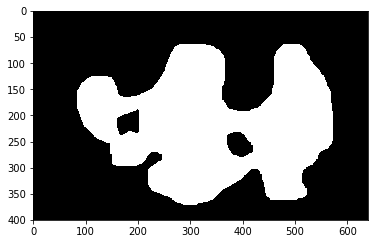

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("test.png")
image = plt.imshow(img)

## グレイスケール化

In [2]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## 関数群

### 範囲や座標変換用
* is_background :指定のピクセルが縁どりたい物体(白)の上にある（False)のか、背景にあるのか（True)を判定する。
* radians_full :point0からpoint1 まで引いた直線がx軸に対してどのくらいの角度になるかを計算。範囲は0〜2${\pi}$
* in_range:指定の数値が範囲内にあるかどうかを判断し、範囲外の場合は末端の値に書き換える
* in_range_polar:上記の関数を使ってpointから半径r, 角度${\theta}$ 行った点を出力する。画像の範囲外に出た場合は末端の値を出力する

In [4]:
def is_background(img, point, background = 0):
    y_max, x_max = img.shape
    x = point[0]
    y = point[1]
    if in_range(x,0,x_max)!= x or in_range(y,0,y_max)!= y:
        return "({},{}) is out of bounds.".format(x,y)
    if img[y][x] == background:
        return True
    else:
        return False

In [6]:
def radians_full(point0,point1):
    x0, y0 = point0
    x1, y1 = point1
    dx = x1 - x0
    dy = y1 - y0
    full_arctan = {
        (1.0,1.0):0,
        (-1.0,1.0):np.pi,
        (-1.0,-1.0):np.pi,
        (1.0,-1.0):2*np.pi        
    }
    if dx == 0 and dy >= 0:
        return 0.5*np.pi
    elif dx == 0 and dy < 0:
        return 1.5 * np.pi
    else:
        return np.arctan(dy/dx) + full_arctan[(dx/abs(dx),(dy+0.000001)/abs(dy+0.000001))]

In [3]:
def in_range(x, x_min, x_max):
    if x > x_max:
        x = x_max
    if x < 0:
        x = 0
    return x

In [7]:
def in_range_polar(img, point, r, theta):
    y_max, x_max = img.shape
    x_max -= 1
    y_max -= 1
    x0, y0 = point
    x = int(x0 + r * np.cos(theta))
    y = int(y0 + r * np.sin(theta))
    theta = radians_full(point,(x,y))
    if in_range(x,0,x_max) != x:
        r = abs((in_range(x,0,x_max) - x0)/np.cos(theta))
        x = int(x0 + r * np.cos(theta))
    if in_range(y,0,y_max) != y:
        r = abs((in_range(y,0,y_max) - y0)/np.sin(theta))
        x = int(x0 + r * np.cos(theta))
        y = int(y0 + r * np.sin(theta))
    return (x, y, r, theta)

## エッジを検出用&グラフプロット用
* find_edge:指定されたlineに沿って画像のピクセルを確認して色の変わった地点をエッジとして座標を出力する。
* edge_trace:指定された点を中心にしてfind_edgeのlineを360°回転してエッジの座標をリストで出力する。
* edgr_plot:edge_traceの座標をmatplotlibで描画。はっきり行って適当。サブプロットしてレイアウトコル気力が残ってなかった。

edge_traceを魚雷が航跡を追いかける方法で実装しようとしたのだけれど、色々やっているうちに跡形もなくなった。残っているのが概念だけ。

In [5]:
def find_edge(img,line):
    try:
        x0,y0,x1,y1 = line
        dx = x1 - x0
        dy = y1 - y0
        r = np.sqrt(dx ** 2 + dy **2)
        step = int(r)
        dr = r/step
        result = (False, "edge not found")
        color = img[y0][x0]
        x = x0
        y = y0
        theta = 0.0
        if dx == 0:
            for i in range(step):
                sign = dy/abs(dy)
                x = x0
                y = int(y + dr*sign)
                if img[y][x] == color:
                    continue
                else:
                    result = (x,y)
                    return result
            return result
        else:
            theta = np.arctan(dy/dx)
        if dx < 0:
            theta += np.pi

        for i in range(step):
            x =int(x0 + dr*i * np.cos(theta))
            y = int(y0 + dr*i * np.sin(theta))
            if img[y][x] == color:
                continue
            else:
                result = (x,y)
                return result
        return result
    except IndexError:
        return result

In [8]:
def edge_trace(img, point, background = 0, search_range = 80):
    if is_background(img, point, background) == True:
        raise TypeError("The point must not be in the background.") 
    else:
        edges = []
        y_max, x_max = img.shape
        y_max -= 1
        x_max -= 1
        x0, y0 = point
        line0 = (x0, y0, x_max, y0)
        x1, y1 = find_edge(img,line0)
        if x1 == False:
            x1, y1 = (x_max, y0)
        r = abs(x1 - x0)
        edges.append((x1,y1))
        #print("x0,y0:",x0,y0)
        #print("x1,y1:",x1,y1)
        #print("r:",r)

        for theta in range(1,360,1):
            theta_rad = np.radians(theta)
            x, y, r, theta_rad = in_range_polar(img, point, r, theta_rad)
            while is_background(img, (x,y), background) == True:
                r -= search_range
                x, y, _, __ = in_range_polar(img, point, r, theta_rad)
                x = int(x0 + r * np.cos(np.radians(theta)))
                if (0<=x<x_max and 0<=y<y_max) == False:
                    break
            r += search_range
            xx, yy, r, __ = in_range_polar(img, point, r, theta_rad)
            while is_background(img, (xx,yy), background) == False:
                r += search_range
                xx, yy, _, __ = in_range_polar(img,point, r, theta_rad)
                if (0<=xx<x_max and 0<=yy<y_max) == False:
                    break
            point2 = find_edge(img, (x,y,xx,yy))
            if point2[0] == False:
                continue
            edges.append(point2)
    return edges

In [9]:
def edge_plot(point, search_range=30, background = 0):
    x,y =point
    plt.scatter(x,y, c = "red")
    y_max, x_max = img.shape

    edges = edge_trace(img, point, search_range = search_range, background = background)

    Xs = [edge[0] for edge in edges]
    Ys = [edge[1] for edge in edges]

    plt.scatter(Xs,Ys)
    plt.gca().invert_yaxis()
    plt.show()

## 実行結果
赤い点を中心にしてlineを一回転して見つけたエッジをプロットしている。4パターン

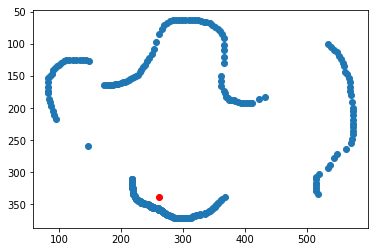

In [10]:
p0 = (262,339)
edge_plot(p0)

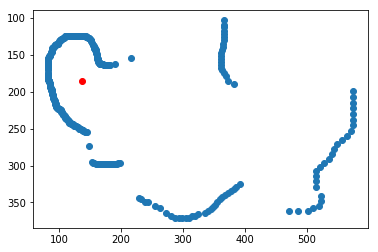

In [11]:
p1 = (137,185)
edge_plot(p1)

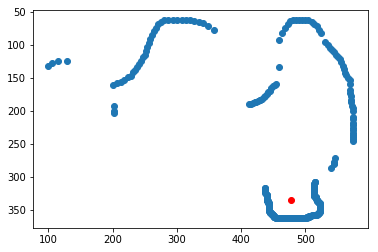

In [12]:
p2 = (478,335)
edge_plot(p2)

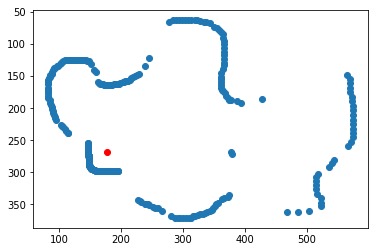

In [13]:
p3 = (177,268)
edge_plot(p3)

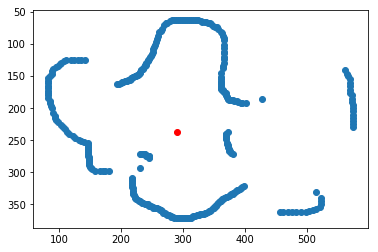

In [14]:
p4 = (290,237)
edge_plot(p4)

## そんなもんかと思ったあなた!

### そんなもんちゃうで！

かなり力技だけどランダムに赤い点を沢山落としてエッジをサーチするとこうなる。

In [41]:
import random
y_max,x_max = img.shape
y_max -= 1
x_max -= 1
edges = []
epoch = 0
iteration = 0
points_all = []

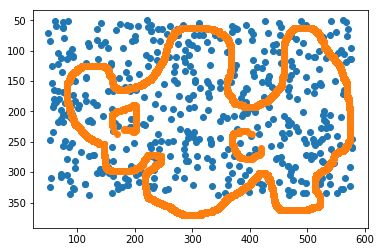

epoch: 5
iteration 259


In [47]:
epoch += 1
N = 100

points = [(random.randint(50,x_max-61),random.randint(50,y_max-61)) for i in range(N)]

for point in points:
    if is_background(img, point) == True:
        continue
    edges.extend(edge_trace(img, point, search_range = 30, background = 0))
    iteration += 1

points_all.extend(points)
Px = [point[0] for point in points_all]
Py = [point[1] for point in points_all]
plt.scatter(Px,Py)
Xs = [edge[0] for edge in edges]
Ys = [edge[1] for edge in edges]
plt.scatter(Xs,Ys)
plt.gca().invert_yaxis()
plt.show()

print("epoch:",epoch)
print("iteration",iteration)

↑　領域内からはみ出した点は捨てている。
この点を使ってペジエ曲線で囲めば閉じた領域を切り出すのはできそう。